# Gold Comparison Capstone: Part 1 - Data Wrangling

For this capstone I have collected a total of five different csv files. They are:
1. "gold-price-last-ten-years.csv"
2. "SP500 2007-2020.csv"
3. "silver history.csv"
4. "Barrick Gold Corp 1985-2020.csv"

The purpose of this capstone is to conduct a small scale test on the belief that the value of GLD increases when the value of stock market indexes decreases (represented by the S&P500 index). To add some additional insight and food for thought, I have included several other sets of data: the value of silver, the stock value of Barrick Gold Corp (a gold mining company), and the value of Bitcoin to the US dollar. The reasoning for including silver is to see if this trend is unique to gold, or if other precious metals increase in value as the stock market declines. The stock value of Barrick Gold Corp. is included in order to see if the stock value of gold mining companies also increases in value in correlation to the value of gold and the S&P500 index.

Hypothesis: When the S&P500 index goes down in value (represented by the S&P500 index), the value of gold increases.

Null Hypothesis: S&P500 index value dropping will not have a statistically significant, positive effect on the stock value of Gold.

After discovering any significant relationships between the indexes/stocks, I will write a time series in order to see how well we can predict one based off of another.

To begin, I will clean the data in order to properly merge and compare it in a single dataframe.

In [1]:
# To begin, I will import the "gold-price-last-ten-years.csv," and "SP500 2007-2020.csv" 
# in order to merge them together along the date column.

import pandas as pd # for importing, reading, cleaning csv files
import numpy as np # for maths, of course
import matplotlib.pyplot as plt # so we can plot
from matplotlib.pylab import rcParams #
import seaborn as sns # so we can beautify the plots
from statsmodels.tsa.stattools import adfuller # for our Dicky Fuller tests.
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf # for visualizing Autocorrelation functions
from statsmodels.graphics.tsaplots import plot_pacf # for visualizing Partial Autocorrelation functions 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.tsatools import add_trend
from statsmodels.tsa.adfvalues import mackinnonp
import itertools as it
import statsmodels.api as sm # in case I think of anything else I need and didn't bring in here
from sklearn.model_selection import train_test_split # For splitting data effectively
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pmdarima as pm
import warnings # For handling error messages.

path = 'C:\\Users\\mccal\\Desktop\\Springboard Files\\Springboard Capstone data\\BTG Capstone\\'

# There is a lot of text prior to the actual columns, so the header has \
# been set appropriatley.
gold = pd.read_csv('gold-price-last-ten-years.csv', sep=',', header=8)

gold.head()

,date,value
0,2010-08-25,1237.50
1,2010-08-26,1240.25
2,2010-08-27,1234.50
3,2010-08-31,1233.50
4,2010-09-01,1250.00


In [2]:
# First things first, change 'date' column to actual date 
# format with 'pd.to_datetime()'
gold['date']=pd.to_datetime(gold['date'])

# Establish which dates we want to focus on and remove the dates we don't care about from the data. I chose
# January 2, 2014 because it was just before Bitcoin hit and it's the start of the first quarter!
focus = (gold['date'] > '2014-12-31') & (gold['date'] <= '2020-08-21')

# Assign into a main data frame to preserve gold in case we want it later
maindf = gold.loc[focus]

maindf.head()

,date,value
1099,2015-01-02,1184.25
1100,2015-01-05,1192.00
1101,2015-01-06,1211.00
1102,2015-01-07,1213.75
1103,2015-01-08,1206.50


In [3]:
# Renaming the columns to something more 'formal' helps me visualize 
# the final plot and table I have in mind.
maindf.columns = ['Date', 'GLD(USD)']
maindf.head()

,Date,GLD(USD)
1099,2015-01-02,1184.25
1100,2015-01-05,1192.00
1101,2015-01-06,1211.00
1102,2015-01-07,1213.75
1103,2015-01-08,1206.50


In [4]:
# We are going to be checking for NaN values in the data quite 
# frequently in order to monitor changes and loss of data as we clean. 
# Best to write a function for checking NaN now and speed things up! Let's
# have a function that gives us the percentage that NaN values make up in 
# the data.
def show_na(df):
    na_df = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
    na_df.columns=['count', '%']
    na_df.sort_values(by='count', ascending = False)
    return na_df
# Use the function
show_na(maindf)

#Sweet, no Nan's thus far.

,count,%
Date,0,0.0
GLD(USD),0,0.0


Now that I have imported and sorted Gold(GLD), it's time to bring in a second dataframe and begin merging them together. 
Each of the dataframes I have for this project have different start dates, but they all have the same end date. So, in order to have consistency across all of the data, I am going to import the Bitcoin(BTC) dataframe next, as it has the most recent start date of 09-17-2014.
Then I will merge BTC along the 'Date' column of our main dataframe. This way the dataframe will only keep the dates which they share.

So, first thing I notice is new Nan's, which means that there were new dates added. This makes sense as Bitcoin is traded all day, every day and the stock market is closed on weekends and certain holidays. So, with that said, we should have about 30% Nan values in the Gold data set. We  will address this at the end. 

In [5]:
# Import the next csv and repeat
SP500=pd.read_csv('SP500 2007-2020.csv', sep=',', header=7)
SP500.head()

,date,value
0,2007-08-27,1466.79
1,2007-08-28,1432.36
2,2007-08-29,1463.76
3,2007-08-30,1457.64
4,2007-08-31,1473.99


In [6]:
SP500['date'] = pd.to_datetime(SP500['date'])
SP500.head()

,date,value
0,2007-08-27,1466.79
1,2007-08-28,1432.36
2,2007-08-29,1463.76
3,2007-08-30,1457.64
4,2007-08-31,1473.99


In [7]:
# Rename columns for appropriate representation.
SP500.columns = ['Date', 'SPX(USD)']
SP500.head()

,Date,SPX(USD)
0,2007-08-27,1466.79
1,2007-08-28,1432.36
2,2007-08-29,1463.76
3,2007-08-30,1457.64
4,2007-08-31,1473.99


In [8]:
# Since GLD and S&P500 are both stock indexes, they should have almost identical Nan's.
maindf=maindf.merge(SP500, how='left', on='Date')
maindf

,Date,GLD(USD),SPX(USD)
0,2015-01-02,1184.25,2058.20
1,2015-01-05,1192.00,2020.58
2,2015-01-06,1211.00,2002.61
3,2015-01-07,1213.75,2025.90
4,2015-01-08,1206.50,2062.14
...,...,...,...
1435,2020-08-17,1949.85,3381.99
1436,2020-08-18,2005.15,3389.78
1437,2020-08-19,1993.15,3374.85
1438,2020-08-20,1928.05,3385.51


In [9]:
show_na(maindf)

,count,%
Date,0,0.000000
GLD(USD),0,0.000000
SPX(USD),35,2.430556


In [10]:
# Again, repeat for the remaining CSV's
barrick = pd.read_csv('Barrick Gold Corp 1985-2020.csv', sep=',', header=9)

barrick.head(5)

,date,open,high,low,close,volume
0,1985-02-04,1.9985,2.1025,1.9985,1.9985,50400
1,1985-02-05,1.9985,2.2065,1.9985,1.9985,18400
2,1985-02-06,2.1025,2.3648,2.1025,2.1025,65600
3,1985-02-07,2.1025,2.2065,2.1025,2.1025,40000
4,1985-02-08,2.1025,2.2065,2.1025,2.1025,25600


In [11]:
barrick['date'] = pd.to_datetime(barrick['date'])
barrick = barrick[['date', 'close']]

In [12]:
barrick.columns = ['Date','GOLD(USD)']
barrick.head()

,Date,GOLD(USD)
0,1985-02-04,1.9985
1,1985-02-05,1.9985
2,1985-02-06,2.1025
3,1985-02-07,2.1025
4,1985-02-08,2.1025


In [13]:
maindf = maindf.merge(barrick, how='left', on='Date')
maindf.head()

,Date,GLD(USD),SPX(USD),GOLD(USD)
0,2015-01-02,1184.25,2058.20,10.4474
1,2015-01-05,1192.00,2020.58,10.4378
2,2015-01-06,1211.00,2002.61,10.7921
3,2015-01-07,1213.75,2025.90,10.6485
4,2015-01-08,1206.50,2062.14,10.3516


In [14]:
show_na(maindf)

,count,%
Date,0,0.000000
GLD(USD),0,0.000000
SPX(USD),35,2.430556
GOLD(USD),35,2.430556


In [15]:
silver = pd.read_csv('silver history.csv', sep=',', header=7)
silver.head()

,date,value
0,2007-08-28,11.83
1,2007-08-29,11.80
2,2007-08-30,11.86
3,2007-08-31,11.95
4,2007-09-03,12.10


In [16]:
silver['date']=pd.to_datetime(silver['date'])
silver.head()

,date,value
0,2007-08-28,11.83
1,2007-08-29,11.80
2,2007-08-30,11.86
3,2007-08-31,11.95
4,2007-09-03,12.10


In [17]:
silver.columns = ['Date', 'SLV(USD)']
silver.head()

,Date,SLV(USD)
0,2007-08-28,11.83
1,2007-08-29,11.80
2,2007-08-30,11.86
3,2007-08-31,11.95
4,2007-09-03,12.10


In [18]:
maindf = maindf.merge(silver, how='left', on='Date')
maindf.head()

,Date,GLD(USD),SPX(USD),GOLD(USD),SLV(USD)
0,2015-01-02,1184.25,2058.20,10.4474,15.71
1,2015-01-05,1192.00,2020.58,10.4378,15.88
2,2015-01-06,1211.00,2002.61,10.7921,16.29
3,2015-01-07,1213.75,2025.90,10.6485,16.33
4,2015-01-08,1206.50,2062.14,10.3516,16.37


In [19]:
# Check for NaN's
show_na(maindf)

,count,%
Date,0,0.000000
GLD(USD),0,0.000000
SPX(USD),35,2.430556
GOLD(USD),35,2.430556
SLV(USD),11,0.763889


In [20]:
# Check for duplicate dates before setting index on "Date"
maindf['Date'].value_counts().head()

2018-12-21    1
2015-04-01    1
2015-08-03    1
2016-12-19    1
2019-05-09    1
Name: Date, dtype: int64

In [21]:
#Set index to 'Date'  for graphing and visualization
maindf= maindf.set_index('Date')
maindf.head()

,GLD(USD),SPX(USD),GOLD(USD),SLV(USD)
Date,,,,
2015-01-02,1184.25,2058.20,10.4474,15.71
2015-01-05,1192.00,2020.58,10.4378,15.88
2015-01-06,1211.00,2002.61,10.7921,16.29
2015-01-07,1213.75,2025.90,10.6485,16.33
2015-01-08,1206.50,2062.14,10.3516,16.37


In [22]:
# Now, to deal with the Nan's. The best option I propose is to forward fill the missing values since 
# the values do not change much over the weekends. Lets be careful, though, and observe the mean, std deviation, 
# etc of each column before we use ffill.
maindf.describe()

,GLD(USD),SPX(USD),GOLD(USD),SLV(USD)
count,1440.000000,1405.000000,1405.000000,1429.000000
mean,1315.668993,2518.914278,14.950097,16.588147
std,172.994346,397.966880,4.686557,1.869756
min,1049.600000,1829.080000,5.751500,11.772000
25%,1213.125000,2110.740000,12.247700,15.350000
50%,1275.900000,2506.850000,14.250000,16.510000
75%,1340.825000,2837.540000,17.433800,17.411000
max,2061.500000,3397.160000,30.130000,29.261000


In [23]:
# Now use ffill to remove the Nan's
maindf = maindf.fillna(axis=0, method='ffill')

In [24]:
# Lets look at the overall summary of each column again.
maindf.describe()

,GLD(USD),SPX(USD),GOLD(USD),SLV(USD)
count,1440.000000,1440.000000,1440.000000,1440.000000
mean,1315.668993,2517.509035,14.951365,16.587083
std,172.994346,398.845185,4.674576,1.866729
min,1049.600000,1829.080000,5.751500,11.772000
25%,1213.125000,2109.645000,12.245300,15.349750
50%,1275.900000,2503.045000,14.259000,16.508500
75%,1340.825000,2836.915000,17.453350,17.411500
max,2061.500000,3397.160000,30.130000,29.261000


So using ffill had no significant impact on the std dev or mean for any of the columns. We can see that the strongest change was probably to silver, with its std dev going from 1.825 to 1.787.  Still, not significant. 

In [25]:
# Double check, but there should't be any nan values now.
maindf.isnull().sum()

GLD(USD)     0
SPX(USD)     0
GOLD(USD)    0
SLV(USD)     0
dtype: int64

Sweet, so everything is clean now. No duplicate dates and no NaN  values. Now lets finally take a look to see if there  is any correlation among these datasets. Lets first look at a timeline graph of all the columns to see if anything stands out.

I am going to save the data as a separate .csv so that we have it saved in case anything happens or we need it on a separate drive.

In [26]:
# Create a new CSV file with the cleaned data


Text(0, 0.5, 'Value(USD)')

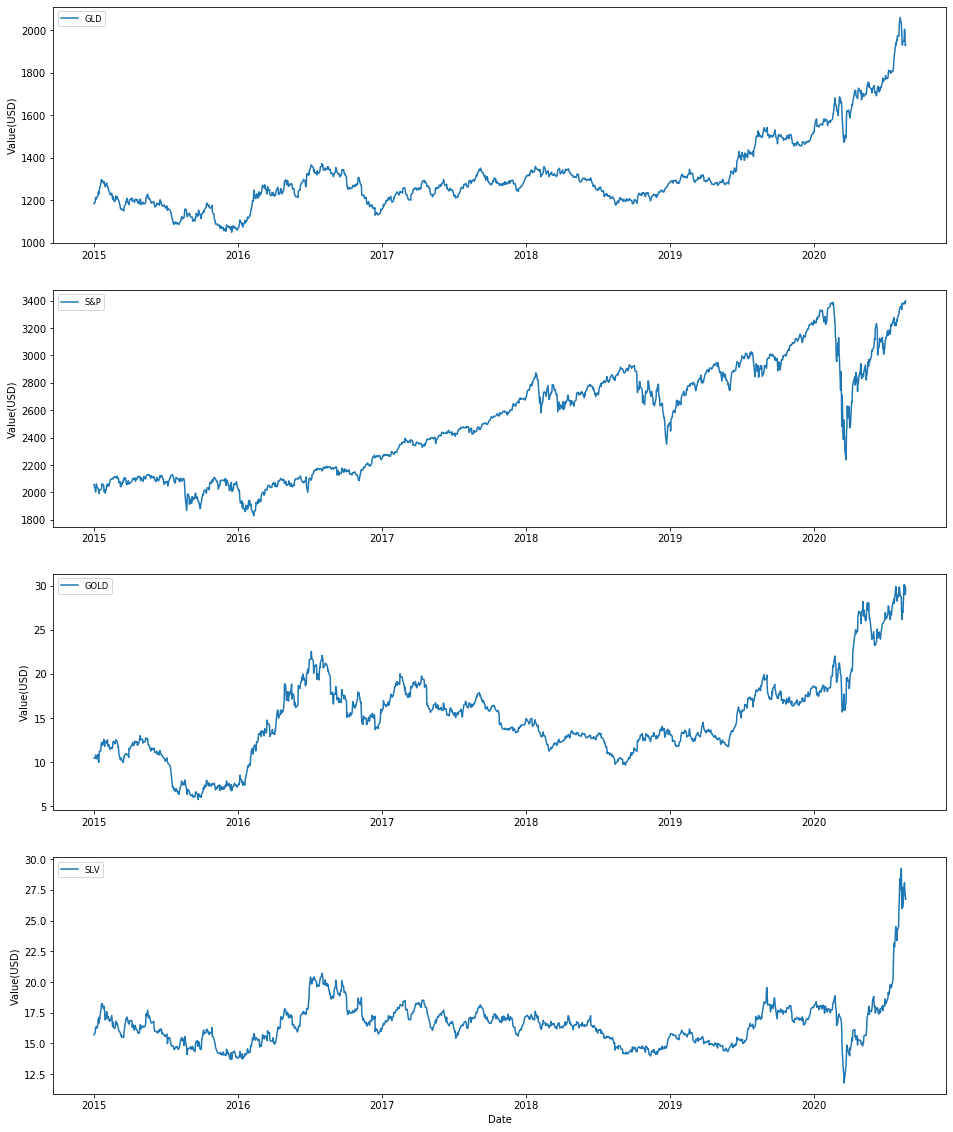

In [27]:
# Take a look at how they compare:
plt.figure(figsize=(16,20))
plt.subplot(411)
plt.plot(maindf['GLD(USD)'], label='GLD')
plt.legend(loc='best', fontsize='small')
plt.ylabel('Value(USD)')
plt.subplot(412)
plt.plot(maindf['SPX(USD)'], label='S&P')
plt.legend(loc='best', fontsize='small')
plt.ylabel('Value(USD)')
plt.subplot(413)
plt.plot(maindf['GOLD(USD)'], label='GOLD')
plt.legend(loc='best', fontsize='small')
plt.ylabel('Value(USD)')
plt.subplot(414)
plt.plot(maindf['SLV(USD)'], label='SLV')
plt.legend(loc='best', fontsize='small')
plt.xlabel('Date')
plt.ylabel('Value(USD)')

Well, just from looking at them, it seems like there might be some truth to this. Around the time of the first lockdowns in 2020 we can clearly see that GLD increased as SPX decreased. Along with this, it seems as Barrick Gold Corp (GOLD) and silver also trended with gold. 

Text(0.5, 1.05, 'Correlation of MainDF Features')

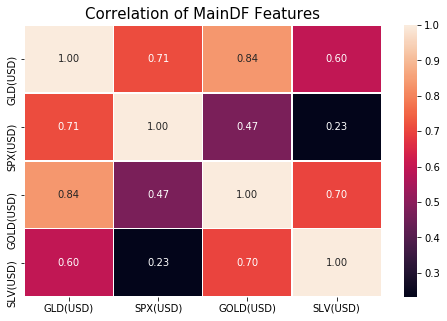

In [28]:
corr = maindf.corr()
plt.figure(figsize = (8,5))
sns.heatmap(corr,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values,
           annot=True, fmt='.2f', linewidths=.30)
plt.title('Correlation of MainDF Features', y =1.05,  size=15)

That's a lot easier to read and make note of correlations. It looks like the value of gold (GLD) is significantly correlated with the value of the SPX. In addition, silvers correlation to Barrick Gold Corp makes sense as they probably trade in silver as well.

In [29]:
# Correlation Scores:
print(corr['GLD(USD)'].sort_values(ascending =False), '\n')

GLD(USD)     1.000000
GOLD(USD)    0.837323
SPX(USD)     0.714047
SLV(USD)     0.596950
Name: GLD(USD), dtype: float64 



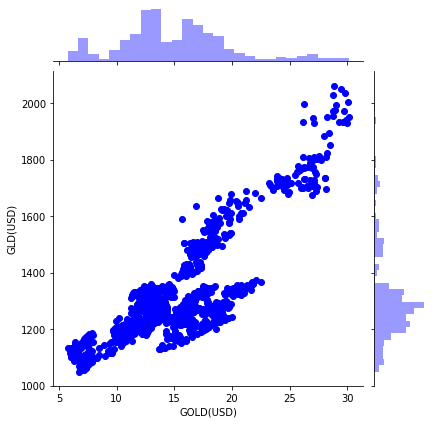

In [30]:
# Using jointplotto visualize relation of GLD with other variables
sns.jointplot(x  = maindf['GOLD(USD)'], y=maindf['GLD(USD)'], color='blue')

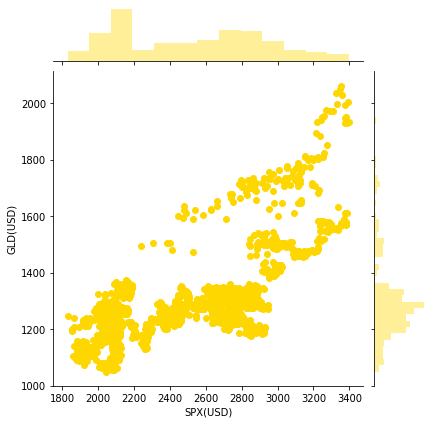

In [31]:
# How about S&P500 and GLD?
sns.jointplot(x= maindf['SPX(USD)'], y=maindf['GLD(USD)'], color='gold')

In [32]:
# Alright, all fun, but lets write the Random Forest Regression test. Remember our hypothesis and null hypothesis in 
# order to assign the right variables to the dependent and independent variables. A quick way to test this is to check
# for cointergration.

SPX = maindf[['SPX(USD)']]
GLD = maindf[['GLD(USD)']]
GOLD= maindf[['GOLD(USD)']]

def adf(ts, maxlag=1):
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)
     
    # Get the dimension of the array
    nobs = ts.shape[0]
         
    # Calculate the discrete difference
    tsdiff = np.diff(ts)
     
    # Create a 2d array of lags, trim invalid observations on both sides
    tsdall = lagmat(tsdiff[:, None], maxlag, trim='both', original='in')
    # Get dimension of the array
    nobs = tsdall.shape[0] 
     
    # replace 0 xdiff with level of x
    tsdall[:, 0] = ts[-nobs - 1:-1]  
    tsdshort = tsdiff[-nobs:]
     
    # Calculate the linear regression using an ordinary least squares model    
    results = OLS(tsdshort, add_trend(tsdall[:, :maxlag + 1], 'c')).fit()
    adfstat = results.tvalues[0]
     
    # Get approx p-value from a precomputed table (from stattools)
    pvalue = mackinnonp(adfstat, 'c', N=1)
    return pvalue
 
def cadf(x, y):
    """
    Returns the result of the Cointegrated Augmented Dickey-Fuller Test
    """
    # Calculate the linear regression between the two time series
    ols_result = OLS(x, y).fit()
     
    # Augmented Dickey-Fuller unit root test
    return adf(ols_result.resid)

print(cadf(SPX, GLD))

0.21649424481129353


Well, they certainly don't have a cointegration score of anything signifcant. Perhaps after we make them a stationary time series more will become clear.

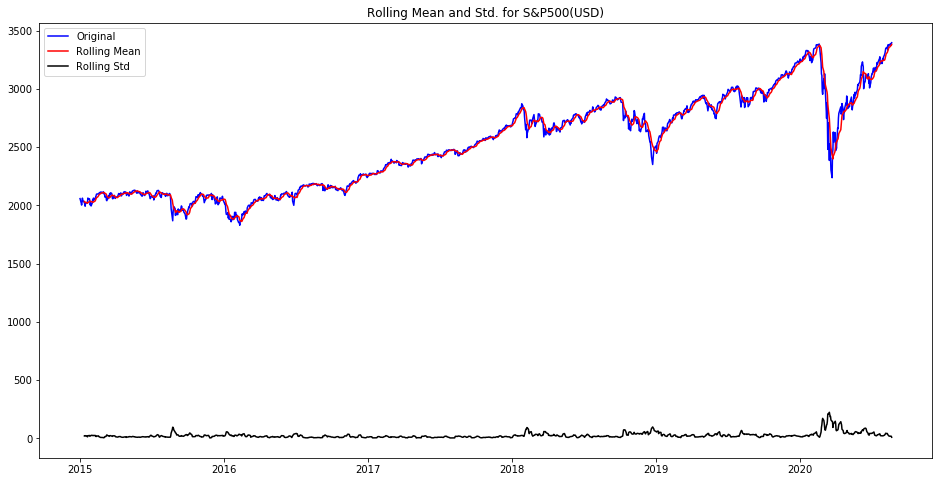

Results of Dickey-Fuller Test:
Test Statistic                   -0.837443
p-value                           0.807875
#Lags used                       13.000000
Number of Observations Used    1426.000000
Critical Value (1%)              -3.434944
Critical Value (5%)              -2.863569
Critical Value (10%)             -2.567850
dtype: float64


In [33]:
# We know from the plots above that our data isn't stationary yet.
# To confirm our visual observation on the above plots, we will use the Dickey-Fuller Hypothesis testing.
# Null Hypothesis: The series is not stationary.
# Alternate Hypothesis: The series is stationary.

# Calculate rolling statistics
rolmean_SPX = SPX.rolling(window=8, center=False).mean()
rolstd_SPX = SPX.rolling(window=8, center=False).std()

# Perform Dicky Fuller Test
dftest_SPX = adfuller(SPX)

# Plot rolling statistics:
fig = plt.figure(figsize=(16,8))
orig = plt.plot(SPX, color='blue', label='Original')
mean =plt.plot(rolmean_SPX, color='red', label='Rolling Mean')
std = plt.plot(rolstd_SPX, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Std. for S&P500(USD)')
plt.show()

# print Dickey-Fuller test results
print('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest_SPX[0:4], index=['Test Statistic', 'p-value','#Lags used', 'Number of Observations Used'])
for key,value in dftest_SPX[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)



ADF Value : -0.9843339833652204
P Value : 0.7589351518036225



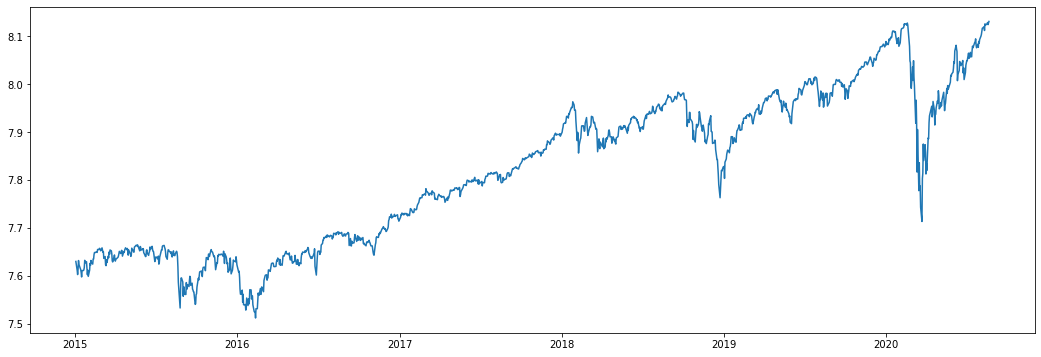

In [34]:
# Alright, that p-value isn't significant yet. Let's try the log now.
plt.figure(figsize=(18,6))
plt.plot(SPX.apply(np.log))

adf_test_log = adfuller(np.log(SPX))
print(f"""
ADF Value : {adf_test_log[0]}
P Value : {adf_test_log[1]}
""")


ADF Value : -9.843684399684733
P Value : 4.6804493553688114e-17



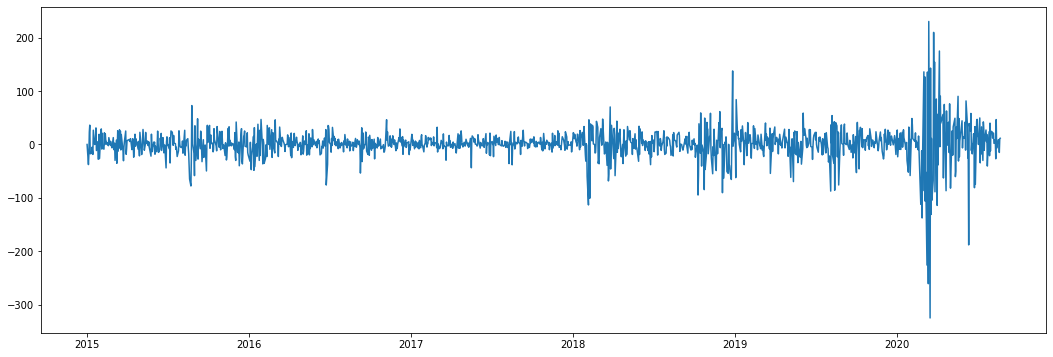

In [35]:
# Still not stationary, so lets try using differencing. We'll start with diff(); which is defaulted to periods=1:
plt.figure(figsize=(18,6))
plt.plot(SPX.diff().fillna(0))

adf_test = adfuller((SPX).diff().fillna(0))
print(f"""
ADF Value : {adf_test[0]}
P Value : {adf_test[1]}
""")

In [36]:
# Sweet, that's far less than the needed p-value of 0.05! Since differencing transforms the data, so let's be sure
# we can preserve the original data we worked so hard to clean!
SPX_stationary = SPX.diff().fillna(0)
SPX_stationary.head()

,SPX(USD)
Date,
2015-01-02,0.00
2015-01-05,-37.62
2015-01-06,-17.97
2015-01-07,23.29
2015-01-08,36.24


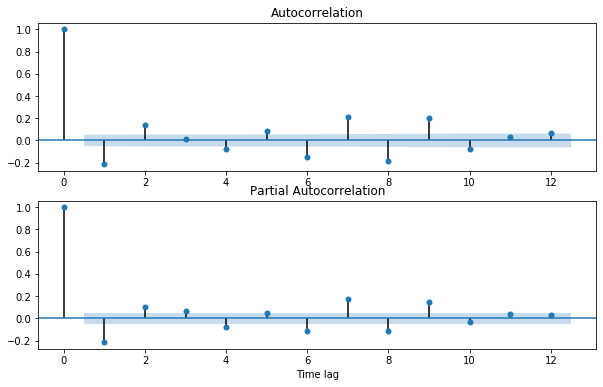

In [37]:
# Calculate ACF and PACF
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(211)
fig = plot_acf(SPX_stationary, lags=12, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(SPX_stationary, lags=12, ax=ax2)
plt.xlabel('Time lag')
plt.show()

In [38]:
# Looks like ACF and PACF point to p=3 and q=3! Now lets train-test-split!

In [39]:
# 01/07/2021 STOP! THIS IS A SEPARATE ATTEMPT AT ARIMAX FROM:
# https://barnesanalytics.com/analyzing-multivariate-time-series-using-arimax-in-python-with-statsmodels
# ADF Test
adf_test_SPX = adfuller(SPX)
print(f"""
ADF Value : {adf_test_SPX[0]}
P Value : {adf_test_SPX[1]}
""")
adf_test_GLD = adfuller(GLD)
print(f"""
ADF Value : {adf_test_GLD[0]}
P Value : {adf_test_GLD[1]}
""")


ADF Value : -0.8374426963544628
P Value : 0.8078754449215946


ADF Value : 1.1188771334857688
P Value : 0.9953745544389053



- ARIMAX is in stats models
- X is usually the exogenous variable
- 3 parameters; AR, I, MAX
- Use the features to predict X


In [40]:
maindf['const'] = 1
model1= sm.OLS(endog=maindf['GLD(USD)'], exog=maindf[['SPX(USD)','const']].dropna())
results1 = model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:               GLD(USD)   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     1496.
Date:                Fri, 08 Jan 2021   Prob (F-statistic):          6.41e-225
Time:                        01:13:34   Log-Likelihood:                -8950.1
No. Observations:                1440   AIC:                         1.790e+04
Df Residuals:                    1438   BIC:                         1.791e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SPX(USD)       0.3097      0.008     38.677      0.0

In [41]:
maindf['diffGLD'] = maindf['GLD(USD)'].diff()
maindf['diffSPX'] = maindf['SPX(USD)'].diff()
model2 = sm.OLS(endog=maindf['diffGLD'].dropna(), exog=maindf[['diffSPX','const']].dropna())
results2 = model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                diffGLD   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5.085
Date:                Fri, 08 Jan 2021   Prob (F-statistic):             0.0243
Time:                        01:13:34   Log-Likelihood:                -5609.0
No. Observations:                1439   AIC:                         1.122e+04
Df Residuals:                    1437   BIC:                         1.123e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
diffSPX        0.0234      0.010      2.255      0.0

In [70]:
granger_results =sm.tsa.stattools.grangercausalitytests(maindf[['GLD(USD)', 'SPX(USD)']].dropna(),1)
print(granger_results)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8764  , p=0.3493  , df_denom=1429, df_num=1
ssr based chi2 test:   chi2=0.8782  , p=0.3487  , df=1
likelihood ratio test: chi2=0.8780  , p=0.3488  , df=1
parameter F test:         F=0.8764  , p=0.3493  , df_denom=1429, df_num=1
{1: ({'ssr_ftest': (0.8764100094760746, 0.34934501599359624, 1429.0, 1), 'ssr_chi2test': (0.8782499185232602, 0.3486814609912724, 1), 'lrtest': (0.8779807119244651, 0.34875534316685397, 1), 'params_ftest': (0.876410009475933, 0.3493450159936399, 1429.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000013505141748>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000013505141CC8>, array([[0., 1., 0.]])])}


In [71]:
print(sm.tsa.stattools.grangercausalitytests(maindf[['SPX(USD)','GLD(USD)']].dropna(),1))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.8546  , p=0.0157  , df_denom=1429, df_num=1
ssr based chi2 test:   chi2=5.8669  , p=0.0154  , df=1
likelihood ratio test: chi2=5.8549  , p=0.0155  , df=1
parameter F test:         F=5.8546  , p=0.0157  , df_denom=1429, df_num=1
{1: ({'ssr_ftest': (5.854611825140471, 0.015660413789786658, 1429.0, 1), 'ssr_chi2test': (5.866902822674006, 0.01542817230669683, 1), 'lrtest': (5.854917200224008, 0.015533588813858993, 1), 'params_ftest': (5.854611825141902, 0.015660413789772443, 1429.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000013505114E08>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000013505114E88>, array([[0., 1., 0.]])])}


In [44]:
def RMSEfromResid(X):
    summ = 0
    for i in X:
        summ+=i**2
    return((summ/len(X))**0.5)

In [47]:
# Train-Test-Split:
date = maindf.index
maindf['SPX_lag']=maindf['diffSPX'].shift()
maindf.dropna(inplace=True)
GLD_end = maindf['GLD(USD)']
SPX_ex = maindf['SPX_lag']
m = len(GLD_end)
size = int(len(GLD_end)*0.8)
train, test = GLD_end[0:size], GLD_end[size:m]
ex_train, ex_test = SPX_ex[0:size], SPX_ex[size:m]
date_test = date[size:]

def evaluate_arimax_model(y, X, model_order):
    model_arimax = ARIMA(endog = y, exog=X, order=model_order).fit()
    AIC = ARIMAResults.aic(model_arimax)
    BIC = ARIMAResults.bic(model_arimax)
    LLF = model_arimax.llf
    RMSE = RMSEfromResid(model_arimax.resid)
    return([AIC, BIC, LLF, RMSE])

warnings.filterwarnings("ignore")
p_values = [0,1,2,3]
d_values = [1]
q_values = [0,1,2]
data = list()
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                [AIC, BIC, LLF, RMSE] = evaluate_arimax_model(train, ex_train, order)
                data.append([order,AIC, BIC, LLF, RMSE])
            except:
                continue

ARIMAX_Models = pd.DataFrame(data,columns=['ARIMAX', 'AIC', 'BIC', 'Maximum Log-Likelihood', 'RMSE'],dtype=float)

evaluate_arimax_model(train, ex_train, order)

TypeError: 'pandas._libs.properties.CachedProperty' object is not callable

Test RMSE: 18.811


ValueError: x and y must have same first dimension, but have shapes (289,) and (288,)

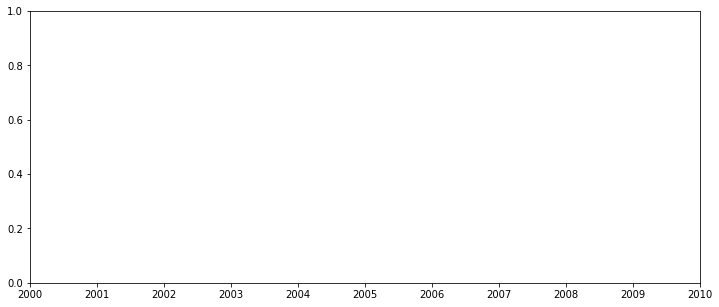

In [52]:
# For predicting from grid search cv
date = maindf.index
maindf['SPX_lag']=maindf['diffSPX'].shift()
maindf.dropna(inplace=True)
GLD_end = maindf['GLD(USD)']
SPX_ex = maindf['SPX_lag']
m = len(GLD_end)
size = int(len(GLD_end)*0.8)
train, test = GLD_end[0:size], GLD_end[size:m]
ex_train, ex_test = SPX_ex[0:size], SPX_ex[size:m]
date_test = date[size:]

history = [x for x in train]
his_u = ex_train
predictions = list()
data=list()
test_index = list()
for t in range(len(ex_test)):
    model_arimax = ARIMA(endog = history,exog=his_u, order=(3, 1, 2)).fit(disp=0)
    output = model_arimax.forecast(steps=1, exog=ex_test.iloc[[t]])
    yhat = output[0]
    predictions.append(yhat)
    history.append(test[t])
    test_index.append(t)
    his_u = ex_train.append(ex_test.iloc[test_index])
    data.append([date_test[t], test[t], yhat])
    
RMSE = (mean_squared_error(test, predictions))**0.5
arima_results = pd.DataFrame(data,columns=['Period','Actual Price', 'Predicted Price'],dtype=float)
print('Test RMSE: %.3f' % RMSE)
# plot
plt.rcParams['figure.figsize'] = (12,5)
plt.plot(date_test, test, color='Blue', label='ACTUAL', marker='x')
plt.plot(date_test, predictions, color='green', label='PREDICTED', marker='x')
plt.legend(loc='upper right')
plt.show()
arimax_pred = predictions
arimax_RMSE = RMSE

In [53]:
maindf['SPX_lag']=maindf['diffSPX'].shift()
maindf.dropna(inplace=True)
model3=sm.tsa.ARIMA(endog=maindf['GLD(USD)'], exog=maindf[['SPX(USD)','SPX_lag']], order=[2,1,0])
results3=model3.fit()
print(results3.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.GLD(USD)   No. Observations:                 1434
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -5588.563
Method:                       css-mle   S.D. of innovations             11.920
Date:                Fri, 08 Jan 2021   AIC                          11189.126
Time:                        01:29:40   BIC                          11220.735
Sample:                             1   HQIC                         11200.928
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -2.5489      2.198     -1.160      0.246      -6.856       1.758
SPX(USD)             0.0012      0.001      1.406      0.160      -0.000       0.003
SPX_lag             -0.0002 

In [55]:
maindf['GLD_lag']=maindf['diffGLD'].shift()
maindf.dropna(inplace=True)
model3=sm.tsa.ARIMA(endog=maindf['SPX(USD)'], exog=maindf[['GLD(USD)','GLD_lag']], order=[2,1,0])
results3=model3.fit()
print(results3.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.SPX(USD)   No. Observations:                 1432
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -6875.778
Method:                       css-mle   S.D. of innovations             29.446
Date:                Fri, 08 Jan 2021   AIC                          13763.556
Time:                        01:29:56   BIC                          13795.157
Sample:                             1   HQIC                         13775.356
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -6.2149      5.474     -1.135      0.256     -16.943       4.513
GLD(USD)             0.0054      0.004      1.320      0.187      -0.003       0.014
GLD_lag              0.0135 

In [56]:

model3=sm.tsa.ARIMA(endog=maindf['GLD(USD)'], exog=maindf['SPX(USD)'], order=[2,1,0])
results3=model3.fit()
print(results3.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.GLD(USD)   No. Observations:                 1432
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -5580.323
Method:                       css-mle   S.D. of innovations             11.917
Date:                Fri, 08 Jan 2021   AIC                          11170.646
Time:                        01:30:22   BIC                          11196.980
Sample:                             1   HQIC                         11180.479
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -2.7344      2.199     -1.244      0.214      -7.044       1.575
SPX(USD)             0.0013      0.001      1.482      0.138      -0.000       0.003
ar.L1.D.GLD(USD)     0.0607 

In [57]:

model3=sm.tsa.ARIMA(endog=maindf['SPX(USD)'], exog=maindf['GLD(USD)'], order=[2,1,0])
results3=model3.fit()
print(results3.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.SPX(USD)   No. Observations:                 1432
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -6875.800
Method:                       css-mle   S.D. of innovations             29.446
Date:                Fri, 08 Jan 2021   AIC                          13761.599
Time:                        01:30:24   BIC                          13787.933
Sample:                             1   HQIC                         13771.432
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -6.4458      5.445     -1.184      0.236     -17.118       4.226
GLD(USD)             0.0056      0.004      1.372      0.170      -0.002       0.014
ar.L1.D.SPX(USD)    -0.1946 